In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,LSTM


import yfinance as yf

Using TensorFlow backend.


In [2]:
#training_data_len=1610
#scaled_data=(2012,1)
#x_train=(1550,60,1)
#y_train=(1550,)

[*********************100%***********************]  1 of 1 completed


/home/prithvi/.espressif/python_env/idf4.2_py2.7_env/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


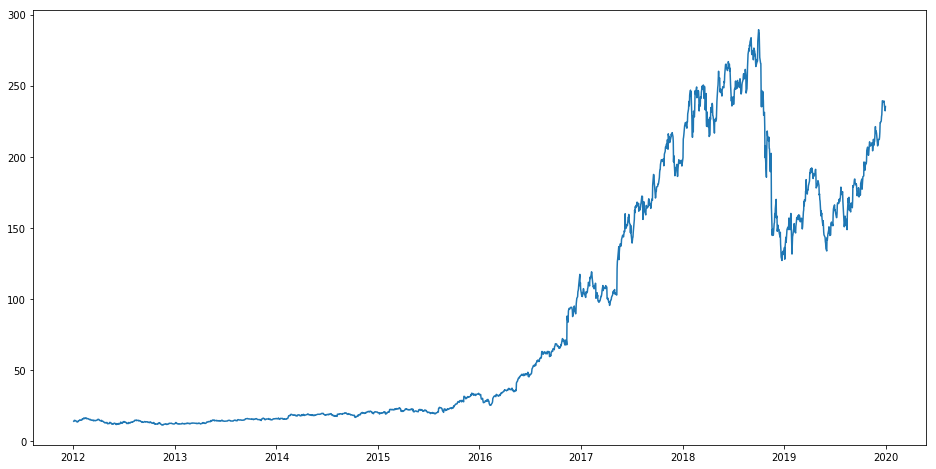

In [3]:
#downloading data from internet of apple stock
df=yf.download('NVDA',start='2012-01-01',end='2020-01-01')
plt.figure(figsize=(16,8))
plt.plot(df['Close'])
plt.show()

In [4]:
df.shape

(2012, 6)

In [5]:
#create a new data with only close column
data=df.filter(['Close'])
#convert to numpy array
dataset=data.values

In [6]:
#1610 out of 2012 for training.ie 80 percent.
training_data_len=math.ceil(0.8*data.shape[0])
training_data_len=int(training_data_len)
print(training_data_len)

1610


In [7]:
data

,Close
Date,
2012-01-03,14.040000
2012-01-04,14.200000
2012-01-05,14.710000
2012-01-06,14.540000
2012-01-09,14.540000
2012-01-10,14.480000
2012-01-11,14.190000
2012-01-12,14.100000
2012-01-13,13.730000


In [8]:
#scale the data
sc=MinMaxScaler(feature_range=(0,1))
scaled_data=sc.fit_transform(data)
print(scaled_data.shape)

(2012, 1)


In [9]:
#create the training data set
train_data=scaled_data[0:training_data_len,:]
#split the train_data into x_train and y_train data sets.
x_train=[]
y_train=[]

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])  #for x in 0 to 59 ,y is 60 ...for x in 1 to 60 y is 61....
    y_train.append(train_data[i,0])

In [10]:
#convert into arrays
x_train,y_train=np.array(x_train),np.array(y_train)
#shape of x_train is (1550,60)
#reshape the data as LSTM accepts 3D data whereas our data is 2D 
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [11]:
#Build The LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
#Compile the model
model.compile(optimizer='adam',loss='mean_squared_error')

In [12]:
#Train the model
model.fit(x_train,y_train,batch_size=1,epochs=3)

Epoch 1/3
1550/1550 [==============================] - 60s 39ms/step - loss: 0.0017
Epoch 2/3
1550/1550 [==============================] - 57s 37ms/step - loss: 6.2041e-04
Epoch 3/3
1550/1550 [==============================] - 57s 36ms/step - loss: 5.2067e-04


In [13]:
#Create a testing data set
#create a new array containing scaled value from index 1550 to 2012
test_data=scaled_data[training_data_len-60:,:]
#create data set x_test and y_test
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [14]:
x_test=np.array(x_test)
#Reshape the data
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_test.shape

(402, 60, 1)

In [146]:
#Get the models predicted price value
predictions=model.predict(x_test)
predictions=sc.inverse_transform(predictions)
print(predictions.shape)

(402, 1)


In [16]:
#Get the root mean square error
rmse=np.sqrt(np.mean(predictions-y_test)**2)
print(rmse)

3.9078113119400557


/home/prithvi/.espressif/python_env/idf4.2_py2.7_env/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


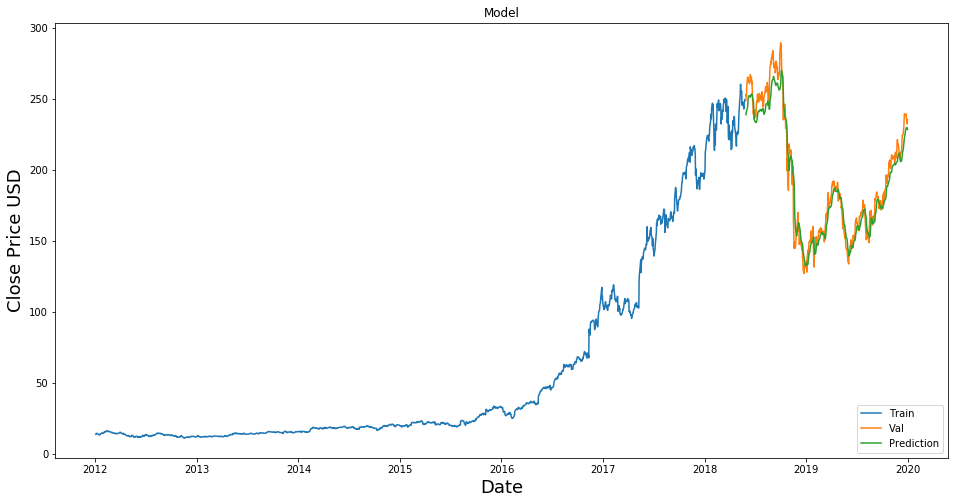

In [17]:
#Plot the data
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions']=predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Prediction'],loc='lower right')


In [57]:
#assembling data for prediction in next one year
future_test=[]
for i in range(1):
    future_test.append(test_data[len(test_data)-60:len(test_data),0])
future_test=np.array(future_test)   
future_test=np.reshape(future_test,(future_test.shape[0],future_test.shape[1],1))
print(future_test.shape)
#prediction of future stock price
future_pred=model.predict(future_test)
future_pred=sc.inverse_transform(future_pred)
print(future_pred)


(1, 60, 1)
[[227.87122]]


In [147]:
#Future prediction of stocks with using the data of only the blue colour on the above plot 
#ie with data upto mid 2018 ..i predicted data upto year 2020.
#future_x_train is my final future x_test matrix that has shape 402*60*1 ....ie data to predict the stock price
future_x_train=[]
xx_test=[]
yy_pred=[]
xxx_test=[]
xx_test=np.array(xx_test)
xxx_test=np.array(xxx_test)
for i in range(len(test_data)-60):
    xx_test=[]
    for j in range(1):
        if i<60:
            xx_test=np.append(xx_test,scaled_data[training_data_len-60+i:training_data_len,0]) 
        else:
            xx_test=np.append(xx_test,yy_pred[i-60:i])

    if i<60:
        xxx_test=np.append(xx_test,np.ravel(yy_pred))
        xx_test=xxx_test
    else:
        xxx_test=xx_test
    xx_test=np.reshape(xx_test,(1,xx_test.shape[0],1))
    print(xx_test.shape)
    pred=model.predict(xx_test)
    yy_pred.append(pred)
    print(xxx_test)
    print(pred)
    print(i)
    future_x_train.append(xxx_test)

(1, 60, 1)
[0.80998635 0.80678468 0.83020367 0.82905248 0.8266782  0.84160736
 0.85754373 0.85016915 0.85387444 0.85603284 0.86013385 0.82603069
 0.85689623 0.85322689 0.82908849 0.79714373 0.83854956 0.77034325
 0.75534217 0.79217932 0.75426295 0.7697317  0.77293336 0.75545009
 0.72980074 0.73397372 0.77894099 0.77293336 0.80300747 0.79185557
 0.79181962 0.81358373 0.8093748  0.78300599 0.7818189  0.76444354
 0.75480253 0.73847045 0.76926402 0.77325712 0.76811283 0.77617099
 0.77318515 0.79721569 0.81905176 0.85365856 0.85984606 0.87919998
 0.89484861 0.87470326 0.87768909 0.84243474 0.84405355 0.85016915
 0.84380177 0.83768623 0.83214623 0.84955754 0.85009718 0.85581701]
[[0.8179077]]
0
(1, 60, 1)
[0.80678468 0.83020367 0.82905248 0.8266782  0.84160736 0.85754373
 0.85016915 0.85387444 0.85603284 0.86013385 0.82603069 0.85689623
 0.85322689 0.82908849 0.79714373 0.83854956 0.77034325 0.75534217
 0.79217932 0.75426295 0.7697317  0.77293336 0.75545009 0.72980074
 0.73397372 0.77894099 

[0.79217932 0.75426295 0.7697317  0.77293336 0.75545009 0.72980074
 0.73397372 0.77894099 0.77293336 0.80300747 0.79185557 0.79181962
 0.81358373 0.8093748  0.78300599 0.7818189  0.76444354 0.75480253
 0.73847045 0.76926402 0.77325712 0.76811283 0.77617099 0.77318515
 0.79721569 0.81905176 0.85365856 0.85984606 0.87919998 0.89484861
 0.87470326 0.87768909 0.84243474 0.84405355 0.85016915 0.84380177
 0.83768623 0.83214623 0.84955754 0.85009718 0.85581701 0.81790769
 0.81246299 0.8048991  0.79692948 0.78920168 0.78193045 0.77515984
 0.76886368 0.76298863 0.75747359 0.75225884 0.74729133 0.74252647
 0.73792851 0.73347026 0.72913128 0.7248978  0.72075993 0.71671188]
[[0.7127492]]
19
(1, 60, 1)
[0.75426295 0.7697317  0.77293336 0.75545009 0.72980074 0.73397372
 0.77894099 0.77293336 0.80300747 0.79185557 0.79181962 0.81358373
 0.8093748  0.78300599 0.7818189  0.76444354 0.75480253 0.73847045
 0.76926402 0.77325712 0.76811283 0.77617099 0.77318515 0.79721569
 0.81905176 0.85365856 0.85984606

[0.77325712 0.76811283 0.77617099 0.77318515 0.79721569 0.81905176
 0.85365856 0.85984606 0.87919998 0.89484861 0.87470326 0.87768909
 0.84243474 0.84405355 0.85016915 0.84380177 0.83768623 0.83214623
 0.84955754 0.85009718 0.85581701 0.81790769 0.81246299 0.8048991
 0.79692948 0.78920168 0.78193045 0.77515984 0.76886368 0.76298863
 0.75747359 0.75225884 0.74729133 0.74252647 0.73792851 0.73347026
 0.72913128 0.7248978  0.72075993 0.71671188 0.71274918 0.70887017
 0.70507288 0.70135629 0.6977194  0.69416082 0.69067943 0.6872735
 0.68394119 0.68068057 0.6774894  0.67436564 0.67130685 0.66831106
 0.66537577 0.66249907 0.65967917 0.6569137  0.65420109 0.65153944]
[[0.6489272]]
39
(1, 60, 1)
[0.76811283 0.77617099 0.77318515 0.79721569 0.81905176 0.85365856
 0.85984606 0.87919998 0.89484861 0.87470326 0.87768909 0.84243474
 0.84405355 0.85016915 0.84380177 0.83768623 0.83214623 0.84955754
 0.85009718 0.85581701 0.81790769 0.81246299 0.8048991  0.79692948
 0.78920168 0.78193045 0.77515984 0

[0.81790769 0.81246299 0.8048991  0.79692948 0.78920168 0.78193045
 0.77515984 0.76886368 0.76298863 0.75747359 0.75225884 0.74729133
 0.74252647 0.73792851 0.73347026 0.72913128 0.7248978  0.72075993
 0.71671188 0.71274918 0.70887017 0.70507288 0.70135629 0.6977194
 0.69416082 0.69067943 0.6872735  0.68394119 0.68068057 0.6774894
 0.67436564 0.67130685 0.66831106 0.66537577 0.66249907 0.65967917
 0.6569137  0.65420109 0.65153944 0.64892721 0.64636272 0.64384454
 0.64137107 0.63894105 0.63655341 0.63420647 0.63189924 0.62963063
 0.62739927 0.62520444 0.62304485 0.62091953 0.6188277  0.61676824
 0.61474043 0.6127432  0.61077601 0.60883772 0.60692781 0.60504544]
[[0.60319006]]
60
(1, 60, 1)
[0.81246299 0.8048991  0.79692948 0.78920168 0.78193045 0.77515984
 0.76886368 0.76298863 0.75747359 0.75225884 0.74729133 0.74252647
 0.73792851 0.73347026 0.72913128 0.7248978  0.72075993 0.71671188
 0.71274918 0.70887017 0.70507288 0.70135629 0.6977194  0.69416082
 0.69067943 0.6872735  0.68394119 

[0.70507288 0.70135629 0.6977194  0.69416082 0.69067943 0.6872735
 0.68394119 0.68068057 0.6774894  0.67436564 0.67130685 0.66831106
 0.66537577 0.66249907 0.65967917 0.6569137  0.65420109 0.65153944
 0.64892721 0.64636272 0.64384454 0.64137107 0.63894105 0.63655341
 0.63420647 0.63189924 0.62963063 0.62739927 0.62520444 0.62304485
 0.62091953 0.6188277  0.61676824 0.61474043 0.6127432  0.61077601
 0.60883772 0.60692781 0.60504544 0.60319006 0.60136068 0.59955692
 0.59777796 0.59602326 0.59429204 0.59258395 0.59089828 0.58923465
 0.5875923  0.58597088 0.58436984 0.58278865 0.581227   0.57968426
 0.57815999 0.57665396 0.57516557 0.57369453 0.57224029 0.57080275]
[[0.56938124]]
81
(1, 60, 1)
[0.70135629 0.6977194  0.69416082 0.69067943 0.6872735  0.68394119
 0.68068057 0.6774894  0.67436564 0.67130685 0.66831106 0.66537577
 0.66249907 0.65967917 0.6569137  0.65420109 0.65153944 0.64892721
 0.64636272 0.64384454 0.64137107 0.63894105 0.63655341 0.63420647
 0.63189924 0.62963063 0.62739927

[0.64137107 0.63894105 0.63655341 0.63420647 0.63189924 0.62963063
 0.62739927 0.62520444 0.62304485 0.62091953 0.6188277  0.61676824
 0.61474043 0.6127432  0.61077601 0.60883772 0.60692781 0.60504544
 0.60319006 0.60136068 0.59955692 0.59777796 0.59602326 0.59429204
 0.59258395 0.59089828 0.58923465 0.5875923  0.58597088 0.58436984
 0.58278865 0.581227   0.57968426 0.57815999 0.57665396 0.57516557
 0.57369453 0.57224029 0.57080275 0.56938124 0.5679757  0.56658542
 0.56521052 0.56385016 0.56250447 0.5611729  0.5598551  0.55855107
 0.55726027 0.55598247 0.55471736 0.55346477 0.5522244  0.55099595
 0.54977936 0.54857421 0.54738021 0.54619741 0.54502541 0.54386395]
[[0.54271287]]
102
(1, 60, 1)
[0.63894105 0.63655341 0.63420647 0.63189924 0.62963063 0.62739927
 0.62520444 0.62304485 0.62091953 0.6188277  0.61676824 0.61474043
 0.6127432  0.61077601 0.60883772 0.60692781 0.60504544 0.60319006
 0.60136068 0.59955692 0.59777796 0.59602326 0.59429204 0.59258395
 0.59089828 0.58923465 0.587592

[[0.5235602]]
120
(1, 60, 1)
[0.60136068 0.59955692 0.59777796 0.59602326 0.59429204 0.59258395
 0.59089828 0.58923465 0.5875923  0.58597088 0.58436984 0.58278865
 0.581227   0.57968426 0.57815999 0.57665396 0.57516557 0.57369453
 0.57224029 0.57080275 0.56938124 0.5679757  0.56658542 0.56521052
 0.56385016 0.56250447 0.5611729  0.5598551  0.55855107 0.55726027
 0.55598247 0.55471736 0.55346477 0.5522244  0.55099595 0.54977936
 0.54857421 0.54738021 0.54619741 0.54502541 0.54386395 0.54271287
 0.54157203 0.54044116 0.53932011 0.53820866 0.53710657 0.5360139
 0.53493005 0.53385526 0.53278911 0.53173149 0.53068233 0.52964139
 0.52860856 0.52758354 0.52656645 0.52555692 0.52455491 0.52356023]
[[0.5225729]]
121
(1, 60, 1)
[0.59955692 0.59777796 0.59602326 0.59429204 0.59258395 0.59089828
 0.58923465 0.5875923  0.58597088 0.58436984 0.58278865 0.581227
 0.57968426 0.57815999 0.57665396 0.57516557 0.57369453 0.57224029
 0.57080275 0.56938124 0.5679757  0.56658542 0.56521052 0.56385016
 0.562

[0.57516557 0.57369453 0.57224029 0.57080275 0.56938124 0.5679757
 0.56658542 0.56521052 0.56385016 0.56250447 0.5611729  0.5598551
 0.55855107 0.55726027 0.55598247 0.55471736 0.55346477 0.5522244
 0.55099595 0.54977936 0.54857421 0.54738021 0.54619741 0.54502541
 0.54386395 0.54271287 0.54157203 0.54044116 0.53932011 0.53820866
 0.53710657 0.5360139  0.53493005 0.53385526 0.53278911 0.53173149
 0.53068233 0.52964139 0.52860856 0.52758354 0.52656645 0.52555692
 0.52455491 0.52356023 0.52257288 0.52159244 0.52061903 0.51965261
 0.51869279 0.51773947 0.51679277 0.51585233 0.51491815 0.5139901
 0.51306814 0.51215196 0.51124173 0.51033711 0.5094381  0.5085445 ]
[[0.50765646]]
137
(1, 60, 1)
[0.57369453 0.57224029 0.57080275 0.56938124 0.5679757  0.56658542
 0.56521052 0.56385016 0.56250447 0.5611729  0.5598551  0.55855107
 0.55726027 0.55598247 0.55471736 0.55346477 0.5522244  0.55099595
 0.54977936 0.54857421 0.54738021 0.54619741 0.54502541 0.54386395
 0.54271287 0.54157203 0.54044116 0

[0.54857421 0.54738021 0.54619741 0.54502541 0.54386395 0.54271287
 0.54157203 0.54044116 0.53932011 0.53820866 0.53710657 0.5360139
 0.53493005 0.53385526 0.53278911 0.53173149 0.53068233 0.52964139
 0.52860856 0.52758354 0.52656645 0.52555692 0.52455491 0.52356023
 0.52257288 0.52159244 0.52061903 0.51965261 0.51869279 0.51773947
 0.51679277 0.51585233 0.51491815 0.5139901  0.51306814 0.51215196
 0.51124173 0.51033711 0.5094381  0.5085445  0.50765646 0.50677365
 0.50589603 0.50502354 0.50415611 0.50329351 0.50243586 0.50158292
 0.50073469 0.4998911  0.49905193 0.49821728 0.49738693 0.49656087
 0.49573904 0.49492133 0.49410766 0.49329799 0.49249214 0.49169022]
[[0.490892]]
157
(1, 60, 1)
[0.54738021 0.54619741 0.54502541 0.54386395 0.54271287 0.54157203
 0.54044116 0.53932011 0.53820866 0.53710657 0.5360139  0.53493005
 0.53385526 0.53278911 0.53173149 0.53068233 0.52964139 0.52860856
 0.52758354 0.52656645 0.52555692 0.52455491 0.52356023 0.52257288
 0.52159244 0.52061903 0.51965261 

[0.52860856 0.52758354 0.52656645 0.52555692 0.52455491 0.52356023
 0.52257288 0.52159244 0.52061903 0.51965261 0.51869279 0.51773947
 0.51679277 0.51585233 0.51491815 0.5139901  0.51306814 0.51215196
 0.51124173 0.51033711 0.5094381  0.5085445  0.50765646 0.50677365
 0.50589603 0.50502354 0.50415611 0.50329351 0.50243586 0.50158292
 0.50073469 0.4998911  0.49905193 0.49821728 0.49738693 0.49656087
 0.49573904 0.49492133 0.49410766 0.49329799 0.49249214 0.49169022
 0.49089199 0.49009752 0.48930669 0.48851937 0.48773557 0.48695534
 0.48617828 0.48540467 0.48463422 0.48386705 0.4831031  0.482342
 0.48158407 0.48082912 0.48007697 0.4793278  0.47858137 0.47783762]
[[0.47709662]]
175
(1, 60, 1)
[0.52758354 0.52656645 0.52555692 0.52455491 0.52356023 0.52257288
 0.52159244 0.52061903 0.51965261 0.51869279 0.51773947 0.51679277
 0.51585233 0.51491815 0.5139901  0.51306814 0.51215196 0.51124173
 0.51033711 0.5094381  0.5085445  0.50765646 0.50677365 0.50589603
 0.50502354 0.50415611 0.50329351

193
(1, 60, 1)
[0.51033711 0.5094381  0.5085445  0.50765646 0.50677365 0.50589603
 0.50502354 0.50415611 0.50329351 0.50243586 0.50158292 0.50073469
 0.4998911  0.49905193 0.49821728 0.49738693 0.49656087 0.49573904
 0.49492133 0.49410766 0.49329799 0.49249214 0.49169022 0.49089199
 0.49009752 0.48930669 0.48851937 0.48773557 0.48695534 0.48617828
 0.48540467 0.48463422 0.48386705 0.4831031  0.482342   0.48158407
 0.48082912 0.48007697 0.4793278  0.47858137 0.47783762 0.47709662
 0.47635829 0.47562253 0.47488928 0.47415853 0.47343016 0.47270429
 0.47198063 0.47125936 0.47054029 0.46982342 0.46910876 0.46839613
 0.46768552 0.46697706 0.46627045 0.46556586 0.46486318 0.46416223]
[[0.46346313]]
194
(1, 60, 1)
[0.5094381  0.5085445  0.50765646 0.50677365 0.50589603 0.50502354
 0.50415611 0.50329351 0.50243586 0.50158292 0.50073469 0.4998911
 0.49905193 0.49821728 0.49738693 0.49656087 0.49573904 0.49492133
 0.49410766 0.49329799 0.49249214 0.49169022 0.49089199 0.49009752
 0.48930669 0.488

[0.49329799 0.49249214 0.49169022 0.49089199 0.49009752 0.48930669
 0.48851937 0.48773557 0.48695534 0.48617828 0.48540467 0.48463422
 0.48386705 0.4831031  0.482342   0.48158407 0.48082912 0.48007697
 0.4793278  0.47858137 0.47783762 0.47709662 0.47635829 0.47562253
 0.47488928 0.47415853 0.47343016 0.47270429 0.47198063 0.47125936
 0.47054029 0.46982342 0.46910876 0.46839613 0.46768552 0.46697706
 0.46627045 0.46556586 0.46486318 0.46416223 0.46346313 0.46276575
 0.46207017 0.46137619 0.46068388 0.45999318 0.45930398 0.45861638
 0.45793021 0.45724547 0.45656216 0.45588017 0.45519954 0.45452023
 0.4538421  0.45316523 0.45248955 0.45181501 0.45114154 0.45046908]
[[0.44979775]]
214
(1, 60, 1)
[0.49249214 0.49169022 0.49089199 0.49009752 0.48930669 0.48851937
 0.48773557 0.48695534 0.48617828 0.48540467 0.48463422 0.48386705
 0.4831031  0.482342   0.48158407 0.48082912 0.48007697 0.4793278
 0.47858137 0.47783762 0.47709662 0.47635829 0.47562253 0.47488928
 0.47415853 0.47343016 0.4727042

[0.47783762 0.47709662 0.47635829 0.47562253 0.47488928 0.47415853
 0.47343016 0.47270429 0.47198063 0.47125936 0.47054029 0.46982342
 0.46910876 0.46839613 0.46768552 0.46697706 0.46627045 0.46556586
 0.46486318 0.46416223 0.46346313 0.46276575 0.46207017 0.46137619
 0.46068388 0.45999318 0.45930398 0.45861638 0.45793021 0.45724547
 0.45656216 0.45588017 0.45519954 0.45452023 0.4538421  0.45316523
 0.45248955 0.45181501 0.45114154 0.45046908 0.44979775 0.44912744
 0.44845802 0.44778955 0.44712198 0.4464553  0.4457894  0.44512433
 0.44445997 0.44379634 0.44313341 0.44247115 0.44180954 0.44114846
 0.44048798 0.43982804 0.43916863 0.43850958 0.43785107 0.43719292]
[[0.43653512]]
234
(1, 60, 1)
[0.47709662 0.47635829 0.47562253 0.47488928 0.47415853 0.47343016
 0.47270429 0.47198063 0.47125936 0.47054029 0.46982342 0.46910876
 0.46839613 0.46768552 0.46697706 0.46627045 0.46556586 0.46486318
 0.46416223 0.46346313 0.46276575 0.46207017 0.46137619 0.46068388
 0.45999318 0.45930398 0.458616

[0.46207017 0.46137619 0.46068388 0.45999318 0.45930398 0.45861638
 0.45793021 0.45724547 0.45656216 0.45588017 0.45519954 0.45452023
 0.4538421  0.45316523 0.45248955 0.45181501 0.45114154 0.45046908
 0.44979775 0.44912744 0.44845802 0.44778955 0.44712198 0.4464553
 0.4457894  0.44512433 0.44445997 0.44379634 0.44313341 0.44247115
 0.44180954 0.44114846 0.44048798 0.43982804 0.43916863 0.43850958
 0.43785107 0.43719292 0.43653512 0.43587768 0.43522042 0.43456358
 0.43390691 0.43325055 0.43259412 0.43193811 0.43128204 0.43062609
 0.42997026 0.42931437 0.42865849 0.4280026  0.42734659 0.42669052
 0.42603433 0.42537791 0.42472136 0.42406452 0.42340738 0.42275006]
[[0.42209238]]
256
(1, 60, 1)
[0.46137619 0.46068388 0.45999318 0.45930398 0.45861638 0.45793021
 0.45724547 0.45656216 0.45588017 0.45519954 0.45452023 0.4538421
 0.45316523 0.45248955 0.45181501 0.45114154 0.45046908 0.44979775
 0.44912744 0.44845802 0.44778955 0.44712198 0.4464553  0.4457894
 0.44512433 0.44445997 0.44379634 

[0.45114154 0.45046908 0.44979775 0.44912744 0.44845802 0.44778955
 0.44712198 0.4464553  0.4457894  0.44512433 0.44445997 0.44379634
 0.44313341 0.44247115 0.44180954 0.44114846 0.44048798 0.43982804
 0.43916863 0.43850958 0.43785107 0.43719292 0.43653512 0.43587768
 0.43522042 0.43456358 0.43390691 0.43325055 0.43259412 0.43193811
 0.43128204 0.43062609 0.42997026 0.42931437 0.42865849 0.4280026
 0.42734659 0.42669052 0.42603433 0.42537791 0.42472136 0.42406452
 0.42340738 0.42275006 0.42209238 0.42143428 0.42077589 0.42011708
 0.41945773 0.41879791 0.41813767 0.41747683 0.41681546 0.41615337
 0.41549081 0.41482747 0.41416341 0.4134987  0.41283321 0.41216689]
[[0.41149974]]
272
(1, 60, 1)
[0.45046908 0.44979775 0.44912744 0.44845802 0.44778955 0.44712198
 0.4464553  0.4457894  0.44512433 0.44445997 0.44379634 0.44313341
 0.44247115 0.44180954 0.44114846 0.44048798 0.43982804 0.43916863
 0.43850958 0.43785107 0.43719292 0.43653512 0.43587768 0.43522042
 0.43456358 0.43390691 0.4332505

[0.44180954 0.44114846 0.44048798 0.43982804 0.43916863 0.43850958
 0.43785107 0.43719292 0.43653512 0.43587768 0.43522042 0.43456358
 0.43390691 0.43325055 0.43259412 0.43193811 0.43128204 0.43062609
 0.42997026 0.42931437 0.42865849 0.4280026  0.42734659 0.42669052
 0.42603433 0.42537791 0.42472136 0.42406452 0.42340738 0.42275006
 0.42209238 0.42143428 0.42077589 0.42011708 0.41945773 0.41879791
 0.41813767 0.41747683 0.41681546 0.41615337 0.41549081 0.41482747
 0.41416341 0.4134987  0.41283321 0.41216689 0.41149974 0.41083181
 0.41016287 0.40949303 0.4088223  0.40815055 0.40747774 0.40680391
 0.406129   0.40545291 0.40477568 0.4040972  0.40341765 0.40273672]
[[0.4020545]]
286
(1, 60, 1)
[0.44114846 0.44048798 0.43982804 0.43916863 0.43850958 0.43785107
 0.43719292 0.43653512 0.43587768 0.43522042 0.43456358 0.43390691
 0.43325055 0.43259412 0.43193811 0.43128204 0.43062609 0.42997026
 0.42931437 0.42865849 0.4280026  0.42734659 0.42669052 0.42603433
 0.42537791 0.42472136 0.4240645

[0.4280026  0.42734659 0.42669052 0.42603433 0.42537791 0.42472136
 0.42406452 0.42340738 0.42275006 0.42209238 0.42143428 0.42077589
 0.42011708 0.41945773 0.41879791 0.41813767 0.41747683 0.41681546
 0.41615337 0.41549081 0.41482747 0.41416341 0.4134987  0.41283321
 0.41216689 0.41149974 0.41083181 0.41016287 0.40949303 0.4088223
 0.40815055 0.40747774 0.40680391 0.406129   0.40545291 0.40477568
 0.4040972  0.40341765 0.40273672 0.40205449 0.40137094 0.40068603
 0.39999974 0.39931202 0.39862281 0.39793211 0.3972398  0.39654601
 0.39585048 0.39515334 0.39445454 0.39375401 0.39305168 0.39234757
 0.39164162 0.39093369 0.39022398 0.38951218 0.38879842 0.38808262]
[[0.3873648]]
307
(1, 60, 1)
[0.42734659 0.42669052 0.42603433 0.42537791 0.42472136 0.42406452
 0.42340738 0.42275006 0.42209238 0.42143428 0.42077589 0.42011708
 0.41945773 0.41879791 0.41813767 0.41747683 0.41681546 0.41615337
 0.41549081 0.41482747 0.41416341 0.4134987  0.41283321 0.41216689
 0.41149974 0.41083181 0.41016287

[0.41482747 0.41416341 0.4134987  0.41283321 0.41216689 0.41149974
 0.41083181 0.41016287 0.40949303 0.4088223  0.40815055 0.40747774
 0.40680391 0.406129   0.40545291 0.40477568 0.4040972  0.40341765
 0.40273672 0.40205449 0.40137094 0.40068603 0.39999974 0.39931202
 0.39862281 0.39793211 0.3972398  0.39654601 0.39585048 0.39515334
 0.39445454 0.39375401 0.39305168 0.39234757 0.39164162 0.39093369
 0.39022398 0.38951218 0.38879842 0.38808262 0.3873648  0.38664472
 0.38592255 0.38519818 0.38447148 0.38374263 0.38301128 0.38227761
 0.38154155 0.38080305 0.38006186 0.3793183  0.37857205 0.37782311
 0.37707162 0.3763172  0.37556016 0.37480009 0.37403727 0.37327147]
[[0.37250262]]
327
(1, 60, 1)
[0.41416341 0.4134987  0.41283321 0.41216689 0.41149974 0.41083181
 0.41016287 0.40949303 0.4088223  0.40815055 0.40747774 0.40680391
 0.406129   0.40545291 0.40477568 0.4040972  0.40341765 0.40273672
 0.40205449 0.40137094 0.40068603 0.39999974 0.39931202 0.39862281
 0.39793211 0.3972398  0.396546

[0.40137094 0.40068603 0.39999974 0.39931202 0.39862281 0.39793211
 0.3972398  0.39654601 0.39585048 0.39515334 0.39445454 0.39375401
 0.39305168 0.39234757 0.39164162 0.39093369 0.39022398 0.38951218
 0.38879842 0.38808262 0.3873648  0.38664472 0.38592255 0.38519818
 0.38447148 0.38374263 0.38301128 0.38227761 0.38154155 0.38080305
 0.38006186 0.3793183  0.37857205 0.37782311 0.37707162 0.3763172
 0.37556016 0.37480009 0.37403727 0.37327147 0.37250262 0.3717308
 0.37095582 0.37017775 0.36939645 0.36861193 0.36782408 0.36703283
 0.36623818 0.36544007 0.36463845 0.36383319 0.36302429 0.3622117
 0.3613953  0.36057508 0.35975099 0.35892296 0.35809088 0.35725474]
[[0.35641444]]
347
(1, 60, 1)
[0.40068603 0.39999974 0.39931202 0.39862281 0.39793211 0.3972398
 0.39654601 0.39585048 0.39515334 0.39445454 0.39375401 0.39305168
 0.39234757 0.39164162 0.39093369 0.39022398 0.38951218 0.38879842
 0.38808262 0.3873648  0.38664472 0.38592255 0.38519818 0.38447148
 0.38374263 0.38301128 0.38227761 0

[0.3873648  0.38664472 0.38592255 0.38519818 0.38447148 0.38374263
 0.38301128 0.38227761 0.38154155 0.38080305 0.38006186 0.3793183
 0.37857205 0.37782311 0.37707162 0.3763172  0.37556016 0.37480009
 0.37403727 0.37327147 0.37250262 0.3717308  0.37095582 0.37017775
 0.36939645 0.36861193 0.36782408 0.36703283 0.36623818 0.36544007
 0.36463845 0.36383319 0.36302429 0.3622117  0.3613953  0.36057508
 0.35975099 0.35892296 0.35809088 0.35725474 0.35641444 0.3555699
 0.35472107 0.35386795 0.35301042 0.35214835 0.3512817  0.35041052
 0.34953457 0.34865379 0.34776825 0.34687775 0.34598219 0.34508157
 0.34417576 0.3432647  0.34234834 0.34142655 0.34049928 0.33956635]
[[0.33862782]]
367
(1, 60, 1)
[0.38664472 0.38592255 0.38519818 0.38447148 0.38374263 0.38301128
 0.38227761 0.38154155 0.38080305 0.38006186 0.3793183  0.37857205
 0.37782311 0.37707162 0.3763172  0.37556016 0.37480009 0.37403727
 0.37327147 0.37250262 0.3717308  0.37095582 0.37017775 0.36939645
 0.36861193 0.36782408 0.36703283

[0.3717308  0.37095582 0.37017775 0.36939645 0.36861193 0.36782408
 0.36703283 0.36623818 0.36544007 0.36463845 0.36383319 0.36302429
 0.3622117  0.3613953  0.36057508 0.35975099 0.35892296 0.35809088
 0.35725474 0.35641444 0.3555699  0.35472107 0.35386795 0.35301042
 0.35214835 0.3512817  0.35041052 0.34953457 0.34865379 0.34776825
 0.34687775 0.34598219 0.34508157 0.34417576 0.3432647  0.34234834
 0.34142655 0.34049928 0.33956635 0.33862782 0.33768344 0.33673322
 0.3357771  0.33481491 0.33384651 0.33287191 0.33189094 0.33090359
 0.32990968 0.32890904 0.32790178 0.32688755 0.32586634 0.3248381
 0.32380265 0.32275981 0.32170957 0.32065183 0.31958634 0.31851304]
[[0.31743187]]
388
(1, 60, 1)
[0.37095582 0.37017775 0.36939645 0.36861193 0.36782408 0.36703283
 0.36623818 0.36544007 0.36463845 0.36383319 0.36302429 0.3622117
 0.3613953  0.36057508 0.35975099 0.35892296 0.35809088 0.35725474
 0.35641444 0.3555699  0.35472107 0.35386795 0.35301042 0.35214835
 0.3512817  0.35041052 0.34953457

In [148]:
future_x_train=np.array(future_x_train)
future_x_train=np.reshape(future_x_train,(future_x_train.shape[0],future_x_train.shape[1],1))
future_x_train.shape

(402, 60, 1)

In [149]:
future_predictions=model.predict(future_x_train)
print(future_predictions.shape)
future_predictions=sc.inverse_transform(future_predictions)

(402, 1)


/home/prithvi/.espressif/python_env/idf4.2_py2.7_env/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/prithvi/.espressif/python_env/idf4.2_py2.7_env/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


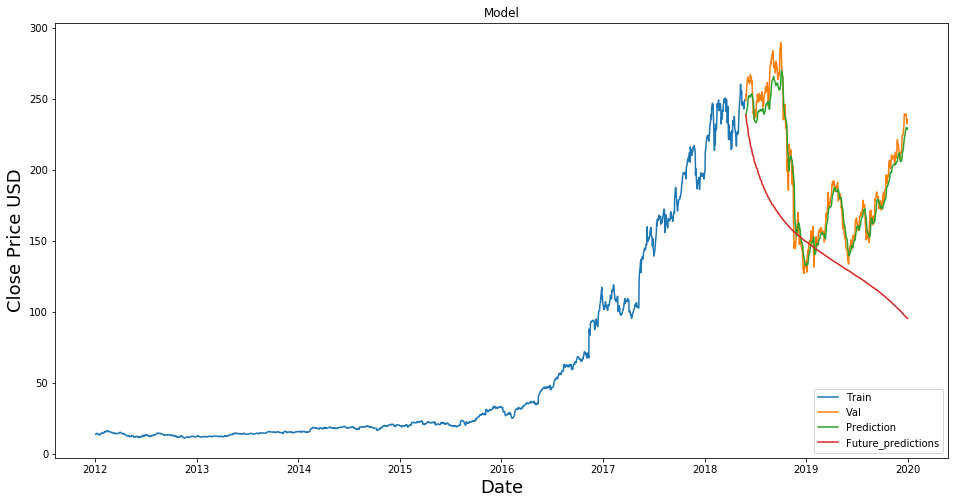

In [151]:
#Plot the data
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions']=predictions
valid['Future_predictions']=future_predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions','Future_predictions']])
plt.legend(['Train','Val','Prediction','Future_predictions'],loc='lower right')
